# Lung differentiation

The direct lung differentiation dataset from *Hurley, K. et al. 
Cell Stem Cell (2020) doi:10.1016/j.stem.2019.12.009*.

This dataset has multiple time points for the state manifold, but only one time point
for the clonal observation on day 27. 

In [1]:
import cospar as cs
import numpy as np

In [2]:
cs.logging.print_version()
cs.settings.verbosity = 2
cs.settings.data_path = "lung_data_paper"  # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path = "lung_figure_paper"  # A relative path to save figures. If not existed before, create a new one.
cs.settings.set_figure_params(
    format="png", dpi=75, fontsize=14
)  # use png to reduce file size.

Running cospar 0.3.0 (python 3.8.16) on 2023-04-12 11:35.


## Load data

In [3]:
adata_orig = cs.datasets.lung()

In [4]:
adata_orig

AnnData object with n_obs × n_vars = 15832 × 26766
    obs: 'time_info', 'state_info'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors'
    obsm: 'X_clone', 'X_emb', 'X_pca'

## Preprocessing (optional)

In [5]:
preprocessing = False
if preprocessing:
    cs.pp.get_highly_variable_genes(
        adata_orig,
        normalized_counts_per_cell=10000,
        min_counts=3,
        min_cells=3,
        min_gene_vscore_pctl=80,
    )

    cs.pp.remove_cell_cycle_correlated_genes(
        adata_orig, corr_threshold=0.03, confirm_change=False
    )  # optional step
    cs.pp.get_X_pca(adata_orig, n_pca_comp=40)
    # cs.pp.get_X_umap(adata_orig,n_neighbors=20,umap_min_dist=0.3) # we want to keep the original embedding
    # cs.pp.get_state_info(adata_orig,leiden_resolution=0.5) # we want to keep the original state annotation

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


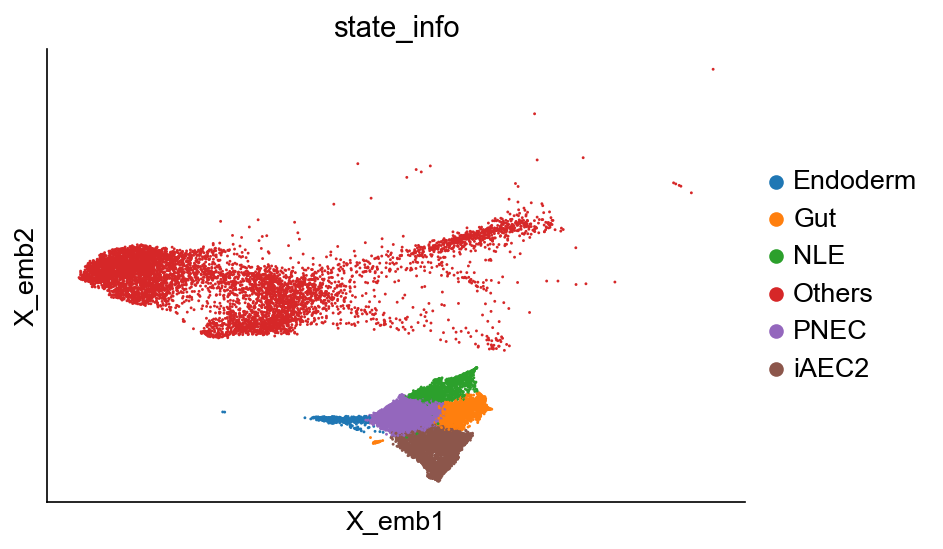

In [6]:
cs.pl.embedding(adata_orig, color="state_info")

In [7]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['NLE', 'Others', 'Gut', 'PNEC', 'iAEC2', 'Endoderm']
Available time points: ['D27' 'pos_17' 'pos_21']
Clonal time points: ['D27']


### Basic clonal analysis

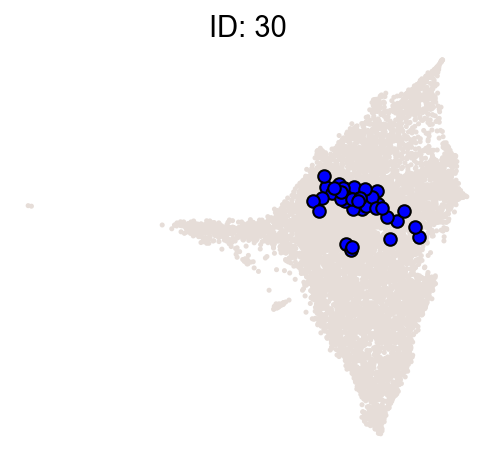

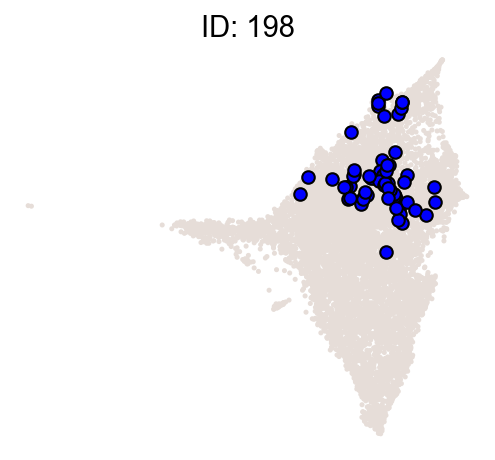

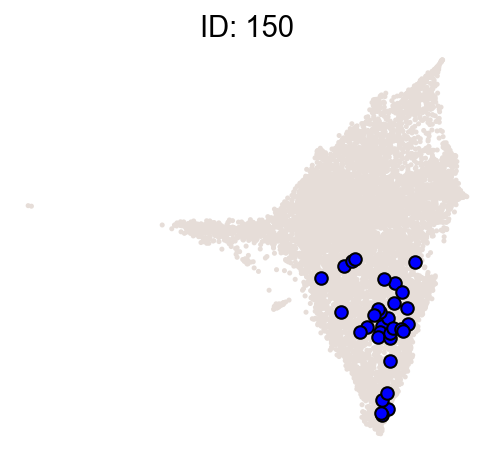

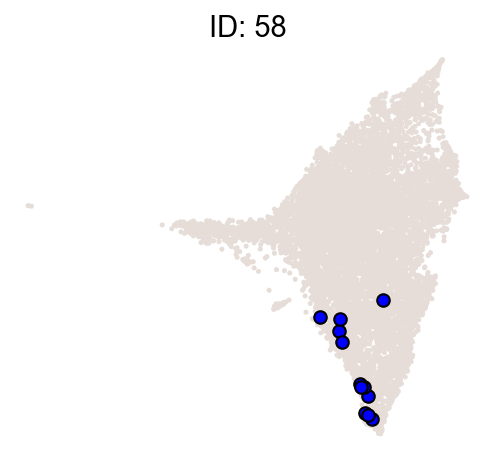

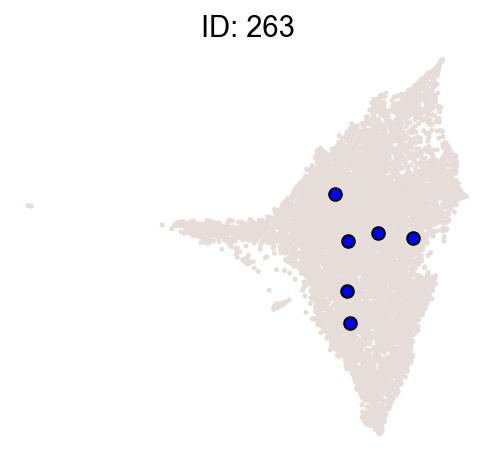

In [8]:
cs.pl.clones_on_manifold(
    adata_orig,
    selected_clone_list=[30, 198, 150, 58, 263],
    color_list=["blue", "red"],
    selected_times=["D27"],
)

Results saved as dictionary at adata.uns['fate_coupling_X_clone']


<Axes: title={'center': 'source: X_clone'}>

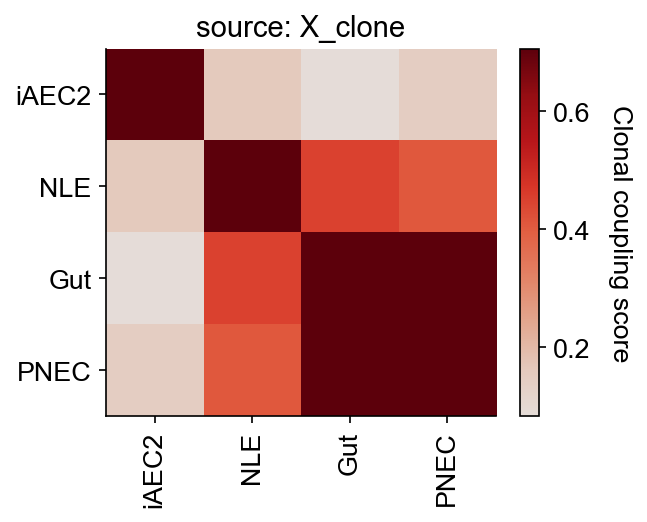

In [9]:
cs.tl.fate_coupling(
    adata_orig,
    source="X_clone",
    selected_fates=["iAEC2", "PNEC", "Gut", "NLE", "Endoderm"],
    normalize=False,
)
cs.pl.fate_coupling(adata_orig, source="X_clone")

Data saved at adata.uns['barcode_heatmap']


<Axes: title={'center': '272 clones'}>

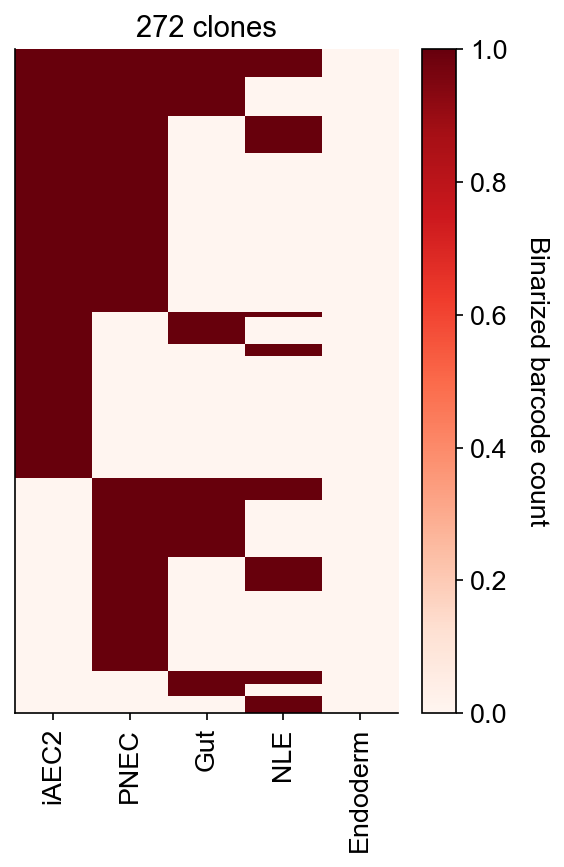

In [10]:
cs.pl.barcode_heatmap(
    adata_orig,
    selected_times="D27",
    selected_fates=["iAEC2", "PNEC", "Gut", "NLE", "Endoderm"],
    binarize=True,
)

100%|███████████████████████████████████████| 272/272 [00:00<00:00, 1087.15it/s]


Data saved at adata.uns['clonal_fate_bias']


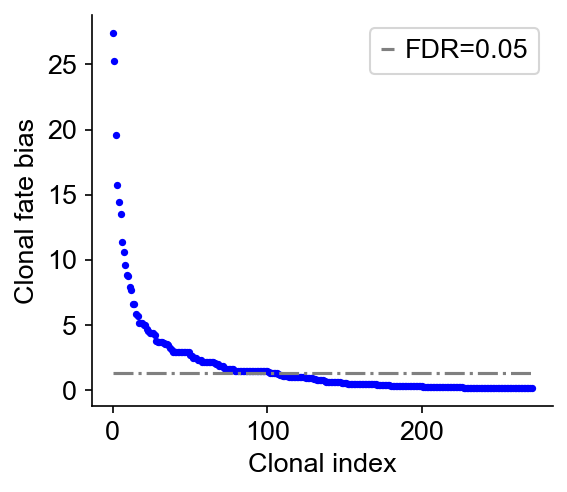

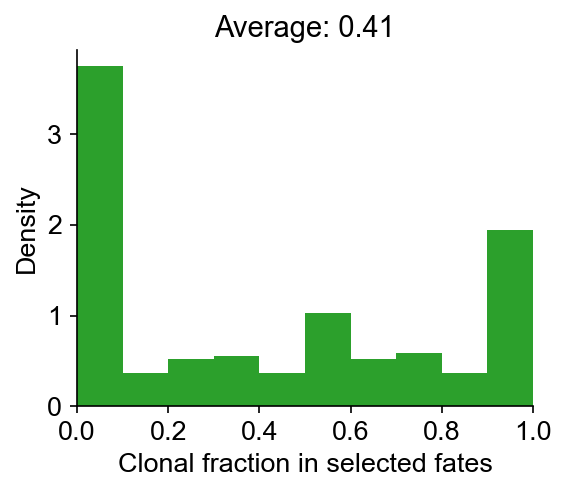

In [11]:
cs.tl.clonal_fate_bias(adata_orig, selected_fate="iAEC2", alternative="two-sided")
cs.pl.clonal_fate_bias(adata_orig)

## Infer transition map from end-point clones

It takes around 9 minutes to run it for the first time (the data has ~15000 cells). Later runs take < 3 mins. 

In [12]:
initial_time_points = ["pos_17", "pos_21"]
clonal_time_point = "D27"
adata = cs.tmap.infer_Tmap_from_one_time_clones(
    adata_orig,
    initial_time_points=["pos_17", "pos_21"],
    later_time_point="D27",
    initialize_method="HighVar",
    HighVar_gene_pctl=80,
    max_iter_N=[1, 3],
    smooth_array=[20, 15, 10],
    sparsity_threshold=0.2,
)

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: pos_17--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 3689 (t1); 3729 (t2). Common set: 1075
Step b: convert the shared highly variable genes into clonal info------


 81%|██████████████████████████████▉       | 875/1075 [00:00<00:00, 1939.43it/s]


Total used genes=875 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.921
Finishing initialization using HighVar, used time 40.56475782394409
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.953
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.511
Finishing Joint Optimization, used time 35.00988531112671
--------Current initial time point: pos_21--------
Step 0: Pre-processing an

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 3794 (t1); 3729 (t2). Common set: 1152
Step b: convert the shared highly variable genes into clonal info------


 97%|███████████████████████████████████▊ | 1115/1152 [00:00<00:00, 1924.26it/s]


Total used genes=1115 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.93
Finishing initialization using HighVar, used time 31.292532920837402
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.98
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.759
Finishing Joint Optimization, used time 22.624002933502197
-----------Total used time: 133.2491409778595 s ------------


### Save pre-computed map

In [13]:
save_data = False
if save_data:
    cs.hf.save_map(adata)

# adata=cs.hf.read('lung_data_paper/Lung_OneTimeClone_t*pos_17*pos_21*D27_adata_with_transition_map.h5ad')

### Plotting

Results saved at adata.obs['fate_map_transition_map_NLE']
Results saved at adata.obs['fate_map_transition_map_Others']
Results saved at adata.obs['fate_map_transition_map_Gut']
Results saved at adata.obs['fate_map_transition_map_PNEC']
Results saved at adata.obs['fate_map_transition_map_iAEC2']
Results saved at adata.obs['fate_map_transition_map_Endoderm']


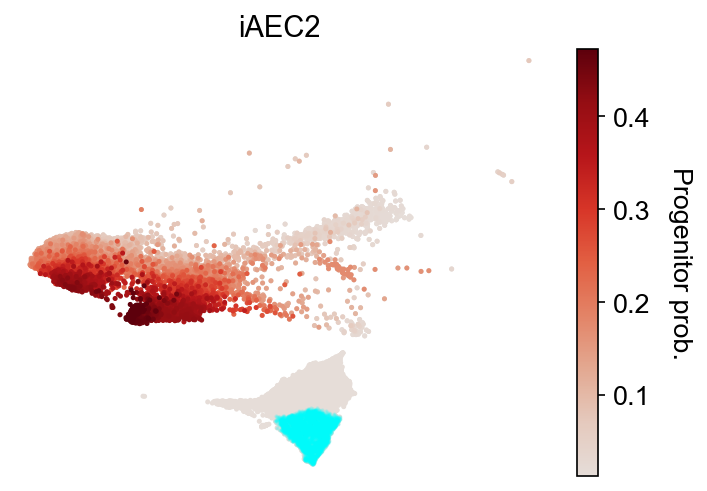

In [14]:
cs.tl.fate_map(adata, source="transition_map", map_backward=True)
cs.pl.fate_map(
    adata, selected_fates=["iAEC2"], source="transition_map", plot_target_state=True
)

Results saved at adata.obs['fate_map_transition_map_iAEC2']
Results saved at adata.obs['fate_map_transition_map_PNEC_Gut_NLE_Endoderm']
Results saved at adata.obs['fate_bias_transition_map_iAEC2*PNEC_Gut_NLE_Endoderm']


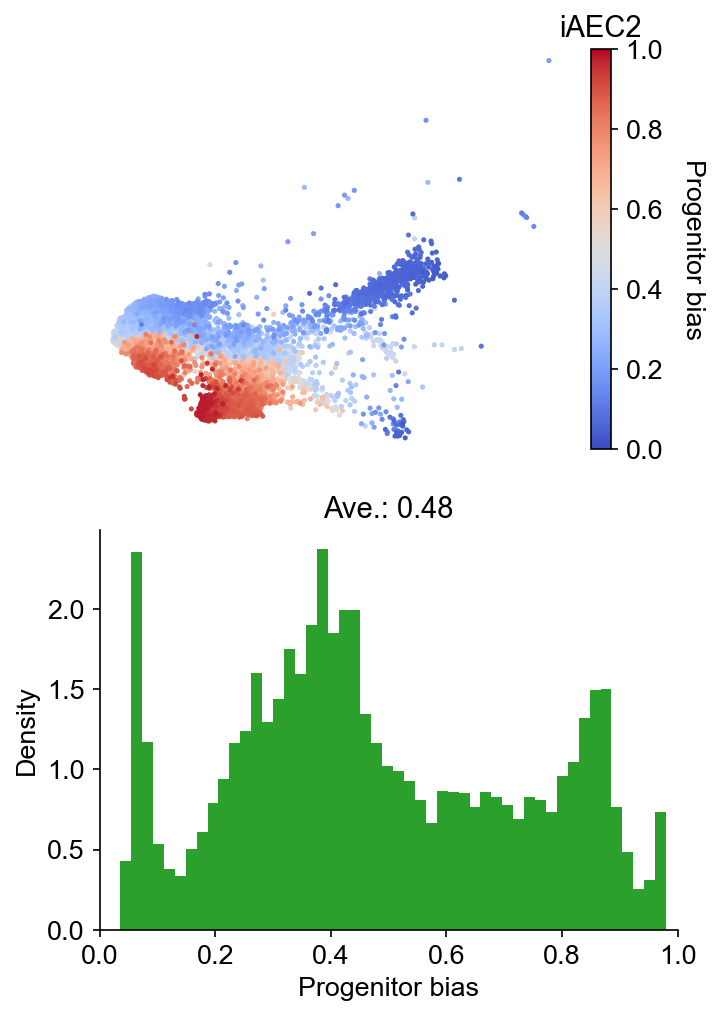

In [15]:
# cs.settings.set_figure_params(figsize=(4,3.5),format='png',fontsize=17)
selected_fates = ["iAEC2", ["PNEC", "Gut", "NLE", "Endoderm"]]
cs.tl.fate_bias(
    adata, selected_fates, source="transition_map", map_backward=True, method="norm-sum"
)
cs.pl.fate_bias(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    plot_target_state=False,
    background=False,
    show_histogram=True,
)

### DGE analysis

Results saved at adata.obs['fate_map_transition_map_iAEC2']
Results saved at adata.obs['fate_map_transition_map_PNEC_Gut_NLE_Endoderm']
Results saved at adata.obs['fate_bias_transition_map_iAEC2*PNEC_Gut_NLE_Endoderm']
Results saved at adata.obs[f'progenitor_transition_map_iAEC2'] and adata.obs[f'diff_trajectory_transition_map_iAEC2']
Results saved at adata.obs[f'progenitor_transition_map_PNEC_Gut_NLE_Endoderm'] and adata.obs[f'diff_trajectory_transition_map_PNEC_Gut_NLE_Endoderm']


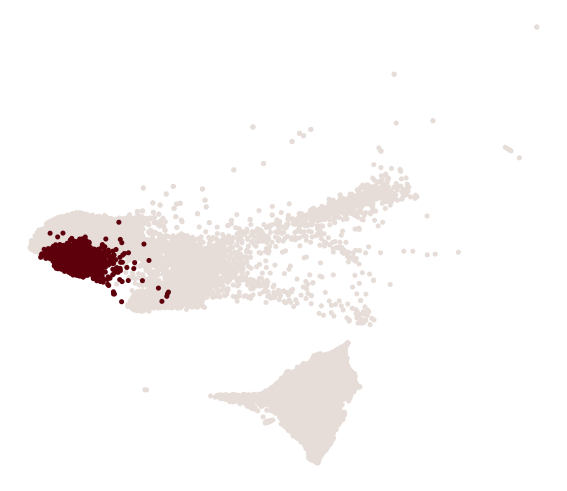

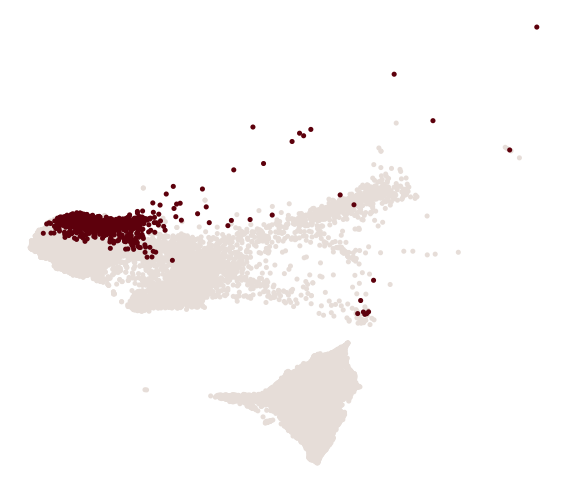

In [16]:
selected_fates = ["iAEC2", ["PNEC", "Gut", "NLE", "Endoderm"]]
cs.tl.progenitor(
    adata,
    selected_fates,
    source="transition_map",
    sum_fate_prob_thresh=0,
    bias_threshold_A=0.6,
    bias_threshold_B=0.3,
)

cs.pl.progenitor(
    adata, selected_fates, source="transition_map", selected_times=["pos_17"]
)

In [17]:
import numpy as np

cell_group_A = np.array(adata.obs["progenitor_transition_map_iAEC2"])
cell_group_B = np.array(adata.obs["progenitor_transition_map_PNEC_Gut_NLE_Endoderm"])
dge_gene_A, dge_gene_B = cs.tl.differential_genes(
    adata, cell_group_A=cell_group_A, cell_group_B=cell_group_B, FDR_cutoff=0.05
)

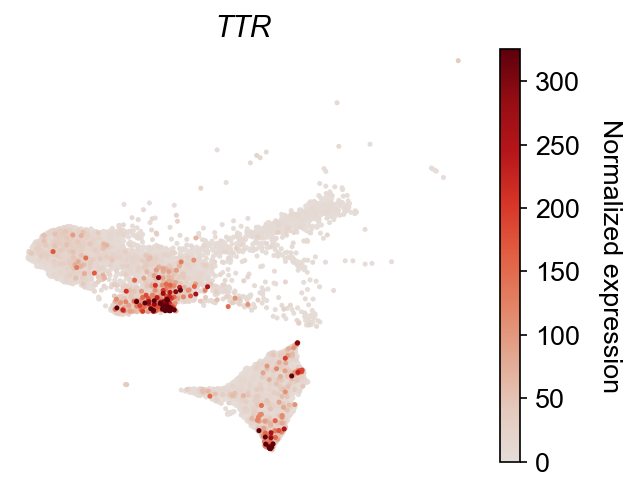

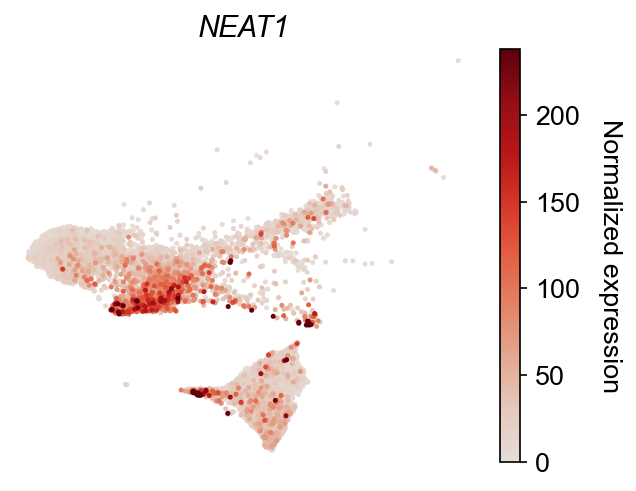

In [18]:
selected_genes = dge_gene_A["gene"][:2]
cs.pl.gene_expression_on_manifold(
    adata, selected_genes=selected_genes, color_bar=True, savefig=False
)

Update cluster annotation

In [19]:
state_info = np.array(adata.obs["state_info"]).astype(">U15")

state_info[cell_group_A > 0] = "iAEC2 prog."
state_info[cell_group_B > 0] = "Non-iAEC2 prog."
adata.obs["state_info"] = state_info

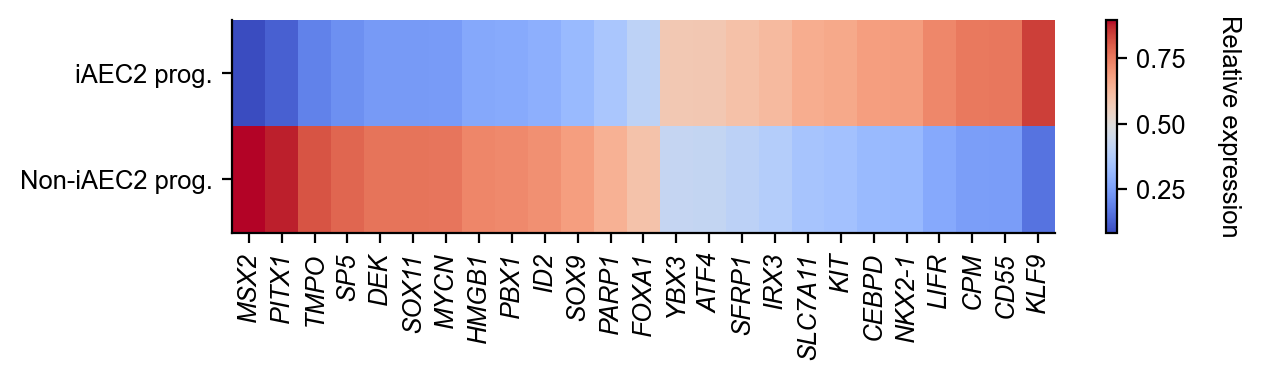

In [20]:
cs.settings.set_figure_params(fontsize=10)
state_info = np.array(adata.obs["state_info"])

gene_list = [
    "KLF9",
    "CEBPD",
    "YBX3",
    "ATF4",
    "NKX2-1",
    "IRX3",
    "SLC7A11",
    "LIFR",  #'HSPA5',
    "SFRP1",
    "CD55",
    "KIT",
    "CPM",  #'LDLR', 'GFRA1',
    "PITX1",
    "MSX2",
    "MYCN",
    "SOX9",
    "SOX11",
    "ID2",
    "PBX1",
    "FOXA1",
    "SP5",
    "TMPO",
    "DEK",
    "HMGB1",
    "PARP1",
]  # , 'TFDP1', 'HNRNPD', 'MYBL2']

selected_fates = ["iAEC2 prog.", "Non-iAEC2 prog."]
renames = ["iAEC2 prog.", "Non-iAEC2 prog."]

gene_expression_matrix = cs.pl.gene_expression_heatmap(
    adata,
    selected_genes=gene_list,
    selected_fates=selected_fates,
    rename_fates=renames,
    horizontal=True,
    fig_width=6.5,
    fig_height=2,
)